In [1]:
#!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Movies_and_TV_5.json.gz

--2022-08-25 08:38:41--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Movies_and_TV_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791322468 (755M) [application/octet-stream]
Saving to: ‘Movies_and_TV_5.json.gz’

Movies_and_TV_5.jso 100%[===================>] 754.66M  44.5MB/s    in 33s     

2022-08-25 08:39:21 (22.8 MB/s) - ‘Movies_and_TV_5.json.gz’ saved [791322468/791322468]



In [2]:
!gunzip Movies_and_TV_5.json.gz

In [1]:
import json
text = []
scores = []
with open("Movies_and_TV_5.json", "r") as f:
  for l in f.readlines():
    d = json.loads(l)
    if "reviewText" in d:
      text.append(d["reviewText"])
      scores.append(d["overall"])

In [2]:
len(text)
import random
random.shuffle(text)

In [3]:
pip install --quiet transformers

Note: you may need to restart the kernel to use updated packages.


In [4]:
from transformers import AutoTokenizer
from transformers import PreTrainedTokenizerFast
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [5]:
def tokens(k):
  text_tok = tokenizer(text[10000 * k:10000 * (k + 1)], padding=True, truncation=True, return_tensors="pt")
  text_tok = text_tok['input_ids']
  text_tok = text_tok[:, :128]
  return text_tok

In [6]:
import torch

In [13]:
class SimpleLanguageModel(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.embedding = torch.nn.Embedding(num_embeddings=30522, embedding_dim=256)
    self.inlayer = torch.nn.LSTM(input_size=256, hidden_size=1024, num_layers=2, batch_first=True)
    self.outlayer = torch.nn.LSTM(input_size=256, hidden_size=1024, num_layers=2, batch_first=True)
    self.output = torch.nn.Conv1d(in_channels=1024, out_channels = 256, kernel_size=1)
    self.output2 = torch.nn.Conv1d(in_channels=256, out_channels = 30522, kernel_size=1)

  def forward(self, input):
    input = self.embedding(input)

    repr = self.inlayer(torch.flip(input, dims=(1,)))[1]
    repr = self.outlayer(input, repr)
    repr = repr[0]
    
    repr = torch.transpose(repr, 1, 2)
    out = self.output2(self.output(repr))
    return out

m = SimpleLanguageModel()
m.cuda()

SimpleLanguageModel(
  (embedding): Embedding(30522, 256)
  (inlayer): LSTM(256, 1024, num_layers=2, batch_first=True)
  (outlayer): LSTM(256, 1024, num_layers=2, batch_first=True)
  (output): Conv1d(1024, 256, kernel_size=(1,), stride=(1,))
  (output2): Conv1d(256, 30522, kernel_size=(1,), stride=(1,))
)

In [14]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(m.parameters(), lr=.0001)
curve = []

In [15]:
for k in range(300):
  text_tok = tokens(k)
  for _ in range(10):
    for _ in range(10):
      optimizer.zero_grad()
      idxs = torch.randint(0, 10000, (64,))
      input_ = text_tok[idxs].cuda()

      outputs = m(input_)

      l = loss(outputs[:, :, :-1], input_[:, 1:])
      l.backward()
      optimizer.step()
      curve.append(l.item())
    print(torch.mean(torch.tensor(curve[-10:])))

tensor(9.5113)
tensor(5.0415)
tensor(4.2970)
tensor(4.2030)
tensor(3.8615)
tensor(3.7603)
tensor(3.7963)
tensor(3.0929)
tensor(2.8679)
tensor(2.7602)
tensor(2.7830)
tensor(2.7335)
tensor(2.7394)
tensor(2.5555)
tensor(2.7178)
tensor(2.7918)
tensor(2.7699)
tensor(2.5689)
tensor(2.4626)
tensor(2.7516)
tensor(2.5873)
tensor(2.6421)
tensor(2.5587)
tensor(2.4985)
tensor(2.5815)
tensor(2.5469)
tensor(2.6575)
tensor(2.6812)
tensor(2.7852)
tensor(2.5342)
tensor(2.5217)
tensor(2.5137)
tensor(2.7981)
tensor(2.5862)
tensor(2.7244)
tensor(2.7350)
tensor(2.6454)
tensor(2.6794)
tensor(2.4242)
tensor(2.6616)
tensor(2.5342)
tensor(2.7267)
tensor(2.5206)
tensor(2.5973)
tensor(2.7631)
tensor(2.4935)
tensor(2.4949)
tensor(2.5724)
tensor(2.7661)
tensor(2.6196)
tensor(2.6725)
tensor(2.4917)
tensor(2.6135)
tensor(2.5850)
tensor(2.4773)
tensor(2.5460)
tensor(2.5208)
tensor(2.3118)
tensor(2.5652)
tensor(2.5098)
tensor(2.6193)
tensor(2.5009)
tensor(2.5508)
tensor(2.4647)
tensor(2.5516)
tensor(2.4347)
tensor(2.4

tensor(1.6027)
tensor(1.6264)
tensor(1.5520)
tensor(1.6561)
tensor(1.5140)
tensor(1.4871)
tensor(1.4839)
tensor(1.4217)
tensor(1.5742)
tensor(1.4765)
tensor(1.4520)
tensor(1.3644)
tensor(1.5771)
tensor(1.4512)
tensor(1.6185)
tensor(1.4874)
tensor(1.4906)
tensor(1.4825)
tensor(1.4079)
tensor(1.3657)
tensor(1.4041)
tensor(1.3019)
tensor(1.4909)
tensor(1.5168)
tensor(1.3890)
tensor(1.4988)
tensor(1.5014)
tensor(1.4861)
tensor(1.4189)
tensor(1.4782)
tensor(1.4681)
tensor(1.4499)
tensor(1.3943)
tensor(1.4813)
tensor(1.5369)
tensor(1.4342)
tensor(1.3745)
tensor(1.5159)
tensor(1.3263)
tensor(1.3945)
tensor(1.3750)
tensor(1.3076)
tensor(1.5029)
tensor(1.3173)
tensor(1.4297)
tensor(1.4457)
tensor(1.4022)
tensor(1.3733)
tensor(1.4394)
tensor(1.3674)
tensor(1.3510)
tensor(1.3736)
tensor(1.4795)
tensor(1.4625)
tensor(1.4992)
tensor(1.4310)
tensor(1.4004)
tensor(1.3903)
tensor(1.4192)
tensor(1.4079)
tensor(1.4902)
tensor(1.4268)
tensor(1.5036)
tensor(1.3151)
tensor(1.5159)
tensor(1.4903)
tensor(1.4

tensor(1.0523)
tensor(0.9624)
tensor(0.9946)
tensor(0.9382)
tensor(0.9304)
tensor(1.0503)
tensor(0.9159)
tensor(1.0122)
tensor(1.0972)
tensor(1.0702)
tensor(1.0736)
tensor(1.0836)
tensor(1.0000)
tensor(0.9294)
tensor(1.0451)
tensor(0.9424)
tensor(1.0387)
tensor(1.0525)
tensor(1.1690)
tensor(1.0345)
tensor(0.9655)
tensor(0.9446)
tensor(0.9106)
tensor(1.0441)
tensor(0.9599)
tensor(1.0730)
tensor(1.0013)
tensor(1.0378)
tensor(0.9714)
tensor(0.9352)
tensor(0.9279)
tensor(0.9642)
tensor(1.0295)
tensor(0.9928)
tensor(0.9175)
tensor(1.0222)
tensor(1.0326)
tensor(0.9475)
tensor(0.9728)
tensor(1.0418)
tensor(1.0099)
tensor(1.0633)
tensor(0.9746)
tensor(0.9029)
tensor(0.9163)
tensor(0.9513)
tensor(1.0776)
tensor(1.0061)
tensor(1.0601)
tensor(0.9828)
tensor(0.9799)
tensor(1.0489)
tensor(0.9794)
tensor(0.9414)
tensor(1.0607)
tensor(1.0046)
tensor(1.0231)
tensor(1.0165)
tensor(0.9232)
tensor(1.0550)
tensor(0.9450)
tensor(0.9830)
tensor(0.9297)
tensor(1.0743)
tensor(0.9350)
tensor(1.0185)
tensor(0.9

tensor(0.7228)
tensor(0.7584)
tensor(0.6870)
tensor(0.7429)
tensor(0.7171)
tensor(0.6755)
tensor(0.7233)
tensor(0.6863)
tensor(0.7501)
tensor(0.8314)
tensor(0.7350)
tensor(0.7647)
tensor(0.7038)
tensor(0.6833)
tensor(0.6779)
tensor(0.7372)
tensor(0.7043)
tensor(0.6940)
tensor(0.7573)
tensor(0.7657)
tensor(0.7076)
tensor(0.7159)
tensor(0.7738)
tensor(0.6168)
tensor(0.7816)
tensor(0.7901)
tensor(0.7333)
tensor(0.6837)
tensor(0.7737)
tensor(0.7455)
tensor(0.6866)
tensor(0.7025)
tensor(0.7803)
tensor(0.6585)
tensor(0.7142)
tensor(0.6769)
tensor(0.6688)
tensor(0.6932)
tensor(0.7562)
tensor(0.6950)
tensor(0.6771)
tensor(0.7355)
tensor(0.6989)
tensor(0.6734)
tensor(0.6791)
tensor(0.6788)
tensor(0.7334)
tensor(0.6287)
tensor(0.8098)
tensor(0.7278)
tensor(0.7034)
tensor(0.6451)
tensor(0.7447)
tensor(0.7414)
tensor(0.7968)
tensor(0.7727)
tensor(0.7484)
tensor(0.6989)
tensor(0.7616)
tensor(0.8047)
tensor(0.6974)
tensor(0.6973)
tensor(0.6778)
tensor(0.7073)
tensor(0.7156)
tensor(0.7076)
tensor(0.6

tensor(0.5574)
tensor(0.5378)
tensor(0.5672)
tensor(0.5611)
tensor(0.5849)
tensor(0.5618)
tensor(0.5661)
tensor(0.5553)
tensor(0.5454)
tensor(0.5250)
tensor(0.5509)
tensor(0.5536)
tensor(0.5552)
tensor(0.5755)
tensor(0.5062)
tensor(0.6145)
tensor(0.5637)
tensor(0.5276)
tensor(0.5094)
tensor(0.5432)
tensor(0.5500)
tensor(0.5852)
tensor(0.4938)
tensor(0.5575)
tensor(0.5679)
tensor(0.5172)
tensor(0.5418)
tensor(0.5572)
tensor(0.5612)
tensor(0.5204)
tensor(0.4784)
tensor(0.5858)
tensor(0.5517)
tensor(0.5560)
tensor(0.5297)
tensor(0.4713)
tensor(0.5072)
tensor(0.4903)
tensor(0.5136)
tensor(0.5425)
tensor(0.4363)
tensor(0.5650)
tensor(0.5173)
tensor(0.5389)
tensor(0.5534)
tensor(0.5422)
tensor(0.5527)
tensor(0.5580)
tensor(0.5312)
tensor(0.5311)
tensor(0.5082)
tensor(0.5071)
tensor(0.5392)
tensor(0.5226)
tensor(0.5827)
tensor(0.6212)
tensor(0.5317)
tensor(0.4571)
tensor(0.5188)
tensor(0.5061)
tensor(0.5167)
tensor(0.5581)
tensor(0.5640)
tensor(0.4577)
tensor(0.5226)
tensor(0.5366)
tensor(0.5

tensor(0.4412)
tensor(0.4010)
tensor(0.3980)
tensor(0.3755)
tensor(0.4706)
tensor(0.4415)
tensor(0.4130)
tensor(0.4128)
tensor(0.4415)
tensor(0.4228)
tensor(0.4525)
tensor(0.4575)
tensor(0.4454)
tensor(0.3831)
tensor(0.3821)
tensor(0.4084)
tensor(0.3760)
tensor(0.4037)
tensor(0.4006)
tensor(0.4327)
tensor(0.4553)
tensor(0.4044)
tensor(0.3827)
tensor(0.4162)
tensor(0.4242)
tensor(0.4075)
tensor(0.4094)
tensor(0.4409)
tensor(0.4149)
tensor(0.4042)
tensor(0.3608)
tensor(0.4208)
tensor(0.3922)
tensor(0.3792)
tensor(0.4373)
tensor(0.4505)
tensor(0.4568)
tensor(0.4137)
tensor(0.4061)
tensor(0.4013)
tensor(0.4235)
tensor(0.4040)
tensor(0.3986)
tensor(0.3743)
tensor(0.4259)
tensor(0.3897)
tensor(0.4070)
tensor(0.4404)
tensor(0.3931)
tensor(0.4012)
tensor(0.4028)
tensor(0.4189)
tensor(0.3806)
tensor(0.3878)
tensor(0.4505)
tensor(0.4126)
tensor(0.4135)
tensor(0.4324)
tensor(0.4041)
tensor(0.4104)
tensor(0.4071)
tensor(0.3991)
tensor(0.4027)
tensor(0.4000)
tensor(0.4099)
tensor(0.4558)
tensor(0.3

In [21]:
len(curve) * 64

1920000

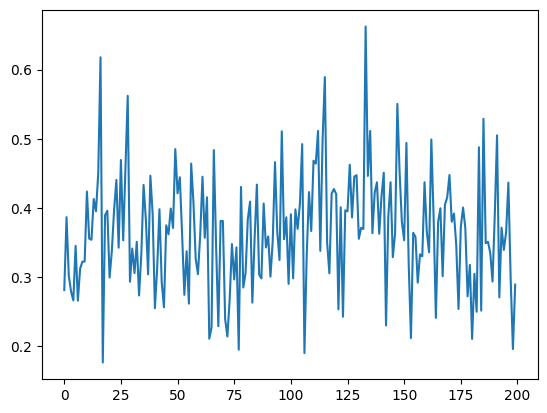

In [24]:
import matplotlib.pyplot as plt
plt.plot(curve[-200:])

In [32]:
tokenizer.decode(input_[12])

'[CLS] i am so over the intentional awkward conversations with the judd apatow effect. with that said i did not love this nor did i hate it. williams is a beauty and i was disappointed when she was not in a scene. completely over seeing dunham naked. if you must show awkwardness then show how characters with no money truly live and not romanticize it! i will not pay for another season unless on prime. that is for sure. weird series. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [33]:
tokenizer.decode(torch.argmax(outputs[12], axis=0))

'i am so over the paint periods conversations with the kidd apatow of. with that said i did who love this nor did i hate it. williams is intrigued beauty and i was disappointed when she was not in a plus. completely slow seeing salham naked. if you must show betterness then much how much have no money sort leave and not romantic - it! i will not pay for me season unless on prime. that is for sure. try.. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [22]:
import footsteps
torch.save(m.state_dict(), footsteps.output_dir + "weights1.pth")
torch.save(curve, footsteps.output_dir + 'learning cu4rve')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Input name of experiment:
memorise_lstm
Saving results to results/memorise_lstm/
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the enviro

In [34]:
8

8